## Elisa Malzoni

___
## Projeto 2-2: Contagem de Pessoas

In [1]:
%reset -f
%matplotlib inline

import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import pickle
from tqdm import tqdm
# from PIL import Image


## Definição da classe codeword

In [2]:
class Codeword():
    def __init__(self, v, aux):
        self.v = v
        self.aux = aux

## Definição das funções de distorção de cor e brilho

In [3]:
def colordist(x, v): 
    normaxt2 = ((x[0]**2) + (x[1]**2) + (x[2]**2))
    normavi2 = ((v[0]**2) + (v[1]**2) +(v[2]**2))
    tupxtvi2 = ((v[0]*x[0]) + (v[1]*x[1]) + (v[2]*x[2]))**2
    if normavi2 == 0:
        p2 = 0
    else:
        p2 = (tupxtvi2/normavi2)

    return math.sqrt(abs((normaxt2) - (p2)))


def brightness(xt, Imax, Imin):
    alpha = 0.4
    beta = 1.1
    Ilow = alpha* Imax
    Ihi = min(beta*Imax, Imin/alpha)
    normaxt= math.sqrt((xt[0]**2) + (xt[1]**2) + (xt[2]**2))
    if (Ilow <= normaxt and normaxt <= Ihi):
        return True
    return False

## Lista das imagens para o treinamento

In [4]:
list_img = ["./Time_13-06/00000036.jpg","./Time_13-06/00000050.jpg",
            "./Time_13-06/00000052.jpg","./Time_13-06/00000060.jpg","./Time_13-06/00000070.jpg",
            "./Time_13-06/00000081.jpg","./Time_13-06/00000093.jpg","./Time_13-06/00000115.jpg",
            "./Time_13-06/00000121.jpg","./Time_13-06/00000140.jpg","./Time_13-06/00000154.jpg",
            "./Time_13-06/00000180.jpg","./Time_13-06/00000190.jpg","./Time_13-06/00000211.jpg",
            "./Time_13-06/00000223.jpg","./Time_13-06/00000240.jpg","./Time_13-06/00000269.jpg",
            "./Time_13-06/00000291.jpg","./Time_13-06/00000300.jpg","./Time_13-06/00000326.jpg",
            "./Time_13-06/00000421.jpg","./Time_13-06/00000425.jpg","./Time_13-06/00000445.jpg",
            "./Time_13-19/00000001.jpg","./Time_13-19/00000082.jpg","./Time_13-19/00000301.jpg",
            "./Time_13-19/00000448.jpg","./Time_13-38/00000031.jpg","./Time_13-38/00000074.jpg",
            "./Time_13-38/00000080.jpg","./Time_13-38/00000088.jpg","./Time_13-38/00000099.jpg",
            "./Time_13-38/00000110.jpg","./Time_13-38/00000130.jpg","./Time_13-38/00000147.jpg",
            "./Time_13-38/00000162.jpg","./Time_13-38/00000178.jpg","./Time_13-38/00000183.jpg",
            "./Time_13-38/00000204.jpg","./Time_13-38/00000222.jpg","./Time_13-38/00000265.jpg",
            "./Time_13-38/00000300.jpg","./Time_13-38/00000320.jpg","./Time_13-38/00000343.jpg",
            "./Time_13-38/00000381.jpg","./Time_13-38/00000400.jpg","./Time_13-38/00000410.jpg",
            "./Time_13-38/00000433.jpg","./Time_13-38/00000450.jpg","./Time_13-38/00000453.jpg"]
N = len(list_img)
img = cv2.imread(list_img[0])

## Criação do conjunto de codebooks e atualizações

In [ ]:
# cria lista de codebooks vazia
C =[]
for i in range(img.shape[0]):
    C.append([])
    for j in range (img.shape[1]):
        C[i].append([])


E1 = 20

# para cada imagem na lista de treinamento
for t in tqdm(range(1, N+1)):

    img1 = cv2.imread(list_img[t-1])
    img = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)
    img = img.astype(float)
    
    for linha in range(img.shape[0]):
        for coluna in range(img.shape[1]):
            
            xt = img[linha, coluna, :]
            I = math.sqrt((xt[0]**2) + (xt[1]**2) + (xt[2]**2))
            match = False
            
            for cw in C[linha][coluna]:
                if (colordist(xt, cw.v) <= E1) and (brightness(xt, cw.aux[1],cw.aux[0])):
                    #atualiza codeword
                    fm = cw.v[2]
                    Rm = (fm*cw.v[0] + xt[0])/ (fm + 1)
                    Gm = (fm*cw.v[1] + xt[1])/ (fm + 1)
                    Bm = (fm*cw.v[2] + xt[2])/ (fm + 1)
                    cw.v = (Rm, Gm, Bm)
                    cw.aux[0] = min(I, cw.aux[0])
                    cw.aux[1] = max(I, cw.aux[1])
                    cw.aux[2] = fm + 1
                    cw.aux[3] = max(cw.aux[3], t - cw.aux[5])
                    cw.aux[4] = cw.aux[4] 
                    cw.aux[5] = t
                    match = True

                    break

            if not match:
                newcw = Codeword(xt, [I, I, 1, t-1, t, t])
                
                C[linha][coluna].append(newcw)

    #atualiza lambda
    for linha in range(img.shape[0]):
        for coluna in range(img.shape[1]):
            for cw in C[linha][coluna]:
                cw.aux[3] = max(cw.aux[3],(N - cw.aux[5] + cw.aux[4] - 1))

# poe conjunto de codebooks no arquivo codebook.p
outfile = open('codebook.p', 'wb')
pickle.dump(C, outfile)
outfile.close()

## Filtro temporal

``` python
Tm = N/2

M =[]
for i in range(img.shape[0]):
    M.append([])
    for j in range (img.shape[1]):
        M[i].append([])


for linha in range(img.shape[0]):
    for coluna in range(img.shape[1]):
        for cw in C[linha][coluna]:
            if cw.aux[3] <= Tm:
                M[linha][coluna].append(cw)
                
    
outfile = open('codebook.p', 'wb')
pickle.dump(M, outfile)
outfile.close()

```

## Lê codebooks do arquivo

In [5]:
infile = open("codebook.p",'rb')
Cr = pickle.load(infile)

## Função que determina background

In [32]:
def BGS(xt, filecd, l, c , E):
    t = 1
    E2 = E
    I = math.sqrt(xt[0]**2 + xt[1]**2 + xt[2]**2)
    for cw in filecd[l][c]:
        if (colordist(xt, cw.v) <= E2) and (brightness(xt,cw.aux[1],cw.aux[0])):
            #atualiza codeword
            fm = cw.v[2]
            Rm = (fm*cw.v[0] + xt[0])/ (fm + 1)
            Gm = (fm*cw.v[1] + xt[1])/ (fm + 1)
            Bm = (fm*cw.v[2] + xt[2])/ (fm + 1)
            cw.v = (Rm, Gm, Bm)
            cw.aux[0] = min(I, cw.aux[0])
            cw.aux[1] = max(I, cw.aux[1])
            cw.aux[2] = fm + 1
            cw.aux[3] = max(cw.aux[3], t - cw.aux[5])
            cw.aux[4] = cw.aux[4] 
            cw.aux[5] = t
            return True
        else:
            return False

## Teste de detecção com imagem do dataset de backgroud com duas pessoas

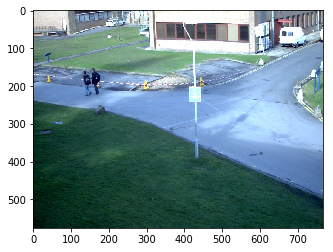

In [21]:
test1 = cv2.imread("./Time_13-06/00000001.jpg")

test = cv2.cvtColor(test1, cv2.COLOR_RGB2BGR)
plt.imshow(test);

In [22]:
new = np.zeros((test.shape[0],test.shape[1]))

E2 = 13

for linha in range(test.shape[0]):
    for coluna in range(test.shape[1]):
        match = BGS(test[linha][coluna], Cr, linha, coluna, E2)
        if not match:
            new[linha][coluna] = 255.0

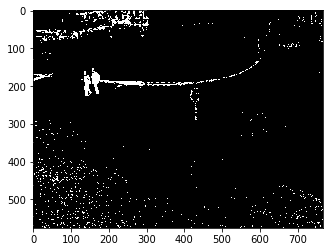

In [23]:
plt.imshow(new, cmap = 'gray');

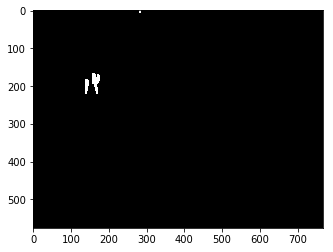

In [24]:
#erodir e dilatar pra tirar ruidos

kernel = np.ones((15,5),np.uint8)
# print(kernel)

opening = cv2.morphologyEx(new, cv2.MORPH_OPEN, kernel)
cv2.imwrite("pessoas.jpg", opening)
plt.imshow(opening, cmap="gray");

numero de pessoas:  2


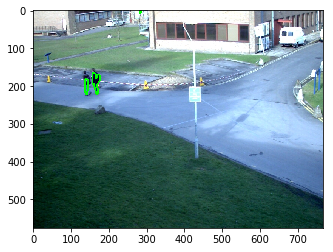

In [25]:
imgray = cv2.imread("pessoas.jpg", cv2.IMREAD_GRAYSCALE)
ret,thresh = cv2.threshold(imgray,127,255,0)
_, contours, _ = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)

pessoas = 0
for c in contours:
    area = cv2.contourArea(c)
    if area > 100:
        cv2.drawContours(test, contours, -1, (0,255,0), 3)
        pessoas += 1
        
print("numero de pessoas: ", pessoas)
plt.imshow(test);

## Teste de detecção com imagem do dataset S1_L1 com multidão

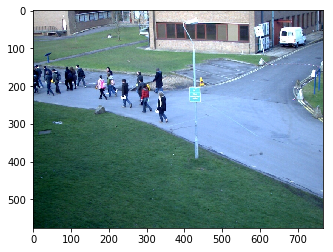

In [26]:
test2 = cv2.imread("./View_001/frame_0195.jpg")

test2 = cv2.cvtColor(test2, cv2.COLOR_RGB2BGR)
plt.imshow(test2);

In [27]:
new2 = np.zeros((test2.shape[0],test2.shape[1]))

E2 = 12

for linha in range(test.shape[0]):
    for coluna in range(test.shape[1]):
        match = BGS(test2[linha][coluna], Cr, linha, coluna, E2)
        if not match:
            new2[linha][coluna] = 255.0

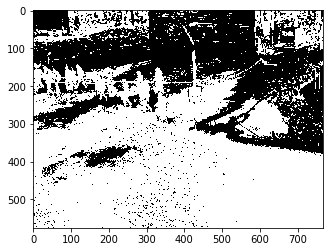

In [28]:
plt.imshow(new2, cmap = 'gray');

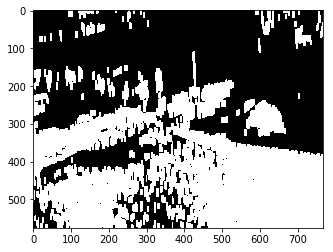

In [29]:
#erodir e dilatar pra tirar ruidos
kernel = np.ones((15,5),np.uint8)

opening = cv2.morphologyEx(new2, cv2.MORPH_OPEN, kernel)
cv2.imwrite("pessoas2.jpg", opening)
plt.imshow(opening, cmap="gray");

numero de pessoas:  77


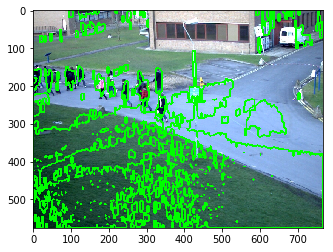

In [30]:
imgray = cv2.imread("pessoas2.jpg", cv2.IMREAD_GRAYSCALE)
ret,thresh = cv2.threshold(imgray,127,255,0)
_, contours, _ = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)

pessoas = 0
for c in contours:
    area = cv2.contourArea(c)
    if area > 100:
        cv2.drawContours(test2, contours, -1, (0,255,0), 3)
        pessoas += 1
        
print("numero de pessoas: ", pessoas)
plt.imshow(test2);

In [31]:
infile.close()